#Predicting News Category With BERT IN Tensorflow

---

Bidirectional Encoder Representations from Transformers or BERT for short is a very popular NLP model from Google known for producing state-of-the-art results in a wide variety of NLP tasks.

The importance of Natural Language Processing(NLP) is profound in the Artificial Intelligence domain. The most abundant data in the world today is in the form of texts and having a powerful text processing system is critical and is more than  just a necessity.

In this article we look at implementing a multi-class classification using the state-of-the-art model, BERT.

---

#####Pre-Requisites:

#####An Understanding of BERT
---

##About Dataset

For this article, we will use MachineHack’s Predict The News Category Hackathon data. The data  consists of a collection of news articles which are categorized into four sections. The features of the datasets are as follows:

Size of training set: 7,628 records
Size of test set: 2,748 records

FEATURES:

STORY:  A part of the main content of the article to be published as a piece of news.
SECTION: The genre/category the STORY falls in.

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :
Politics: 0
Technology: 1
Entertainment: 2
Business: 3


##Mounting Google Drive

---
Here I have uploaded the dataset in to my Google Drive folder. To access the datasets we must first mount the drive in google colab. Type in and enter the following code to authenticate and mount your Google drive on to colab.



In [2]:
!pip install tensorflow_hub

## Importing Necessary Libraries

In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.13.1
tensorflow_hub version :  0.7.0


In [4]:
#Installing BERT module
!pip install bert-tensorflow

In [5]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

##Setting The Output Directory
---
While fine-tuning the model, we will save the training checkpoints and the model in an output directory so that we can use the trained model for our predictions later.

The following code block sets an output directory :



In [6]:
# Set the output directory for saving model file
OUTPUT_DIR = 'C:\\Users\\orion.darley\\Desktop\\Stanford_AI\\CS224'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: C:\Users\orion.darley\Desktop\Stanford_AI\CS224 *****


##Loading The Data
---
We will now load the data from a Google Drive directory and will also split the training set in to training and validation sets.


In [60]:
df = pd.read_csv('C:\\Users\\orion.darley\\Desktop\\Stanford_AI\\CS224\\Bank CFPB Complaints.csv')
df = df.drop(['Date received', 'Sub-product','Company public response', 'Company', 
              'Date sent to company', 'Complaint ID'], axis = 1)
df = df.rename(columns={'Company response to consumer': 'y'})
#Filter dataframe for outliers
df = df[df.groupby('ZIP code')['ZIP code'].transform('size') >  550]
df = df[df['Submitted via'] != 'Email']
df = df[df['Consumer consent provided?'] != 'Consent withdrawn']
df['issue2'] = df['Issue'].astype(str) + ' ' + df['Sub-issue'].astype(str)
df = df.drop(['Issue', 'Sub-issue'], axis = 1)

thedata = df[['issue2', 'y']]
thedata['y'] = thedata['y'].replace({'Closed with explanation': 1, 'Closed with non-monetary relief': 2, 
                             'Closed with monetary relief': 3, 'Closed': 4, 'Closed without relief': 5,
                            'Untimely response': 6, 'Closed with relief': 7, 'In progress': 8})
print(thedata.head())

                                               issue2  y
0   Attempts to collect debt not owed Debt is not ...  1
2   Incorrect information on your report Informati...  1
4    Communication tactics Frequent or repeated calls  1
8   Problem with a credit reporting company's inve...  1
11  Incorrect information on your report Informati...  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [61]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(thedata, test_size=0.25)

train, val = train_test_split(train, test_size=0.2, random_state=1)

In [62]:
test = test.drop(['y'], axis = 1)

In [63]:
#Training set sample
print(train.head(5))
#Test set sample
print(test.head())

                                                   issue2  y
971650                                  Fraud or scam nan  1
257572  Incorrect information on your report Informati...  8
248089  Incorrect information on your report Account s...  2
179422  Attempts to collect debt not owed Debt was res...  1
138204  Problem when making payments You never receive...  2
                                                   issue2
784619  Incorrect information on credit report Account...
263607  False statements or representation Attempted t...
814385                              Billing statement nan
70789   Improper use of your report Credit inquiries o...
322806  Incorrect information on your report Informati...


In [64]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
print("Test Set Shape :", test.shape)

Training Set Shape : (146606, 2)
Validation Set Shape : (36652, 2)
Test Set Shape : (61087, 1)


In [65]:
#Features in the dataset
train.columns

Index(['issue2', 'y'], dtype='object')

In [66]:
#unique classes
train['y'].unique()

array([1, 8, 2, 3, 7, 5, 4, 6], dtype=int64)

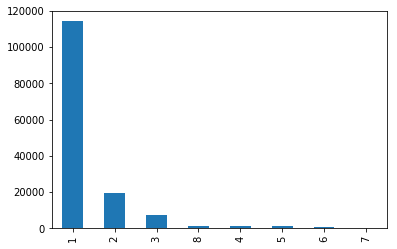

In [67]:
#Distribution of classes
train['y'].value_counts().plot(kind = 'bar')

In [68]:
DATA_COLUMN = 'issue2'
LABEL_COLUMN = 'y'
# The list containing all the classes (train['SECTION'].unique())
label_list = [1, 2, 3, 4, 5, 6, 7, 8]

## Data Preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

* guid : A unique id that represents an observation.
* text_a : The text we need to classify into given categories
* text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.
* label: It consists of the labels or classes or categories that a given text belongs to.
 
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.


In [69]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [70]:
train_InputExamples

971650     <bert.run_classifier.InputExample object at 0x...
257572     <bert.run_classifier.InputExample object at 0x...
248089     <bert.run_classifier.InputExample object at 0x...
179422     <bert.run_classifier.InputExample object at 0x...
138204     <bert.run_classifier.InputExample object at 0x...
84099      <bert.run_classifier.InputExample object at 0x...
124770     <bert.run_classifier.InputExample object at 0x...
258804     <bert.run_classifier.InputExample object at 0x...
930422     <bert.run_classifier.InputExample object at 0x...
324678     <bert.run_classifier.InputExample object at 0x...
301946     <bert.run_classifier.InputExample object at 0x...
670131     <bert.run_classifier.InputExample object at 0x...
274098     <bert.run_classifier.InputExample object at 0x...
912835     <bert.run_classifier.InputExample object at 0x...
869618     <bert.run_classifier.InputExample object at 0x...
184243     <bert.run_classifier.InputExample object at 0x...
66894      <bert.run_cla

In [71]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  Fraud or scam nan

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  1


We will now get down to business with the pretrained BERT.  In this example we will use the ```bert_uncased_L-12_H-768_A-12/1``` model. To check all available versions click [here](https://tfhub.dev/s?network-architecture=transformer&publisher=google).

We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

---

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.


In [72]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0304 11:18:42.420493 855372 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [73]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['fraud', 'or', 'sc', '##am', 'nan']


We will now format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [74]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 146606


I0304 11:18:43.060061 855372 run_classifier.py:774] Writing example 0 of 146606


INFO:tensorflow:*** Example ***


I0304 11:18:43.062027 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:18:43.063027 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] fraud or sc ##am nan [SEP]


I0304 11:18:43.065020 855372 run_classifier.py:464] tokens: [CLS] fraud or sc ##am nan [SEP]


INFO:tensorflow:input_ids: 101 9861 2030 8040 3286 16660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.066017 855372 run_classifier.py:465] input_ids: 101 9861 2030 8040 3286 16660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.068014 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.070007 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0304 11:18:43.071006 855372 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0304 11:18:43.072002 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:18:43.072999 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] incorrect information on your report information belongs to someone else [SEP]


I0304 11:18:43.074994 855372 run_classifier.py:464] tokens: [CLS] incorrect information on your report information belongs to someone else [SEP]


INFO:tensorflow:input_ids: 101 16542 2592 2006 2115 3189 2592 7460 2000 2619 2842 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.075990 855372 run_classifier.py:465] input_ids: 101 16542 2592 2006 2115 3189 2592 7460 2000 2619 2842 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.076990 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.078982 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 8 (id = 7)


I0304 11:18:43.079984 855372 run_classifier.py:468] label: 8 (id = 7)


INFO:tensorflow:*** Example ***


I0304 11:18:43.081974 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:18:43.083969 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] incorrect information on your report account status incorrect [SEP]


I0304 11:18:43.084969 855372 run_classifier.py:464] tokens: [CLS] incorrect information on your report account status incorrect [SEP]


INFO:tensorflow:input_ids: 101 16542 2592 2006 2115 3189 4070 3570 16542 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.085966 855372 run_classifier.py:465] input_ids: 101 16542 2592 2006 2115 3189 4070 3570 16542 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.086963 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.088958 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 1)


I0304 11:18:43.090952 855372 run_classifier.py:468] label: 2 (id = 1)


INFO:tensorflow:*** Example ***


I0304 11:18:43.092946 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:18:43.093943 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] attempts to collect debt not owed debt was result of identity theft [SEP]


I0304 11:18:43.095937 855372 run_classifier.py:464] tokens: [CLS] attempts to collect debt not owed debt was result of identity theft [SEP]


INFO:tensorflow:input_ids: 101 4740 2000 8145 7016 2025 12232 7016 2001 2765 1997 4767 11933 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.096936 855372 run_classifier.py:465] input_ids: 101 4740 2000 8145 7016 2025 12232 7016 2001 2765 1997 4767 11933 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.097933 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.098929 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0304 11:18:43.099928 855372 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0304 11:18:43.101923 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:18:43.102921 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] problem when making payments you never received your bill or did not know a payment was due [SEP]


I0304 11:18:43.103918 855372 run_classifier.py:464] tokens: [CLS] problem when making payments you never received your bill or did not know a payment was due [SEP]


INFO:tensorflow:input_ids: 101 3291 2043 2437 10504 2017 2196 2363 2115 3021 2030 2106 2025 2113 1037 7909 2001 2349 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.104915 855372 run_classifier.py:465] input_ids: 101 3291 2043 2437 10504 2017 2196 2363 2115 3021 2030 2106 2025 2113 1037 7909 2001 2349 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.105912 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:18:43.107907 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 1)


I0304 11:18:43.108905 855372 run_classifier.py:468] label: 2 (id = 1)


INFO:tensorflow:Writing example 10000 of 146606


I0304 11:18:45.860540 855372 run_classifier.py:774] Writing example 10000 of 146606


INFO:tensorflow:Writing example 20000 of 146606


I0304 11:18:48.914703 855372 run_classifier.py:774] Writing example 20000 of 146606


INFO:tensorflow:Writing example 30000 of 146606


I0304 11:18:51.477971 855372 run_classifier.py:774] Writing example 30000 of 146606


INFO:tensorflow:Writing example 40000 of 146606


I0304 11:18:53.929104 855372 run_classifier.py:774] Writing example 40000 of 146606


INFO:tensorflow:Writing example 50000 of 146606


I0304 11:18:56.419401 855372 run_classifier.py:774] Writing example 50000 of 146606


INFO:tensorflow:Writing example 60000 of 146606


I0304 11:18:58.960645 855372 run_classifier.py:774] Writing example 60000 of 146606


INFO:tensorflow:Writing example 70000 of 146606


I0304 11:19:01.693478 855372 run_classifier.py:774] Writing example 70000 of 146606


INFO:tensorflow:Writing example 80000 of 146606


I0304 11:19:03.854601 855372 run_classifier.py:774] Writing example 80000 of 146606


INFO:tensorflow:Writing example 90000 of 146606


I0304 11:19:06.217646 855372 run_classifier.py:774] Writing example 90000 of 146606


INFO:tensorflow:Writing example 100000 of 146606


I0304 11:19:08.997739 855372 run_classifier.py:774] Writing example 100000 of 146606


INFO:tensorflow:Writing example 110000 of 146606


I0304 11:19:11.873111 855372 run_classifier.py:774] Writing example 110000 of 146606


INFO:tensorflow:Writing example 120000 of 146606


I0304 11:19:16.197133 855372 run_classifier.py:774] Writing example 120000 of 146606


INFO:tensorflow:Writing example 130000 of 146606


I0304 11:19:19.154304 855372 run_classifier.py:774] Writing example 130000 of 146606


INFO:tensorflow:Writing example 140000 of 146606


I0304 11:19:21.645375 855372 run_classifier.py:774] Writing example 140000 of 146606


INFO:tensorflow:Writing example 0 of 36652


I0304 11:19:23.268300 855372 run_classifier.py:774] Writing example 0 of 36652


INFO:tensorflow:*** Example ***


I0304 11:19:23.270240 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:19:23.271239 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] credit reporting company ' s investigation problem with statement of dispute [SEP]


I0304 11:19:23.272236 855372 run_classifier.py:464] tokens: [CLS] credit reporting company ' s investigation problem with statement of dispute [SEP]


INFO:tensorflow:input_ids: 101 4923 7316 2194 1005 1055 4812 3291 2007 4861 1997 7593 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.273234 855372 run_classifier.py:465] input_ids: 101 4923 7316 2194 1005 1055 4812 3291 2007 4861 1997 7593 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.274230 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.275226 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0304 11:19:23.277257 855372 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0304 11:19:23.279217 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:19:23.280451 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] incorrect information on your report information belongs to someone else [SEP]


I0304 11:19:23.282208 855372 run_classifier.py:464] tokens: [CLS] incorrect information on your report information belongs to someone else [SEP]


INFO:tensorflow:input_ids: 101 16542 2592 2006 2115 3189 2592 7460 2000 2619 2842 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.284204 855372 run_classifier.py:465] input_ids: 101 16542 2592 2006 2115 3189 2592 7460 2000 2619 2842 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.285201 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.287196 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0304 11:19:23.288484 855372 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0304 11:19:23.290473 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:19:23.291470 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] applying for a mortgage or ref ##ina ##nc ##ing an existing mortgage nan [SEP]


I0304 11:19:23.292467 855372 run_classifier.py:464] tokens: [CLS] applying for a mortgage or ref ##ina ##nc ##ing an existing mortgage nan [SEP]


INFO:tensorflow:input_ids: 101 11243 2005 1037 14344 2030 25416 3981 12273 2075 2019 4493 14344 16660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.294461 855372 run_classifier.py:465] input_ids: 101 11243 2005 1037 14344 2030 25416 3981 12273 2075 2019 4493 14344 16660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.295458 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.296455 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0304 11:19:23.297453 855372 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0304 11:19:23.299447 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:19:23.305432 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] other features , terms , or problems other problem [SEP]


I0304 11:19:23.306429 855372 run_classifier.py:464] tokens: [CLS] other features , terms , or problems other problem [SEP]


INFO:tensorflow:input_ids: 101 2060 2838 1010 3408 1010 2030 3471 2060 3291 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.308425 855372 run_classifier.py:465] input_ids: 101 2060 2838 1010 3408 1010 2030 3471 2060 3291 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.309422 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.311415 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 1)


I0304 11:19:23.312413 855372 run_classifier.py:468] label: 2 (id = 1)


INFO:tensorflow:*** Example ***


I0304 11:19:23.314409 855372 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0304 11:19:23.316402 855372 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] unable to get credit report / credit score problem getting my free annual report [SEP]


I0304 11:19:23.317400 855372 run_classifier.py:464] tokens: [CLS] unable to get credit report / credit score problem getting my free annual report [SEP]


INFO:tensorflow:input_ids: 101 4039 2000 2131 4923 3189 1013 4923 3556 3291 2893 2026 2489 3296 3189 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.318398 855372 run_classifier.py:465] input_ids: 101 4039 2000 2131 4923 3189 1013 4923 3556 3291 2893 2026 2489 3296 3189 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.319394 855372 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0304 11:19:23.321392 855372 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 1)


I0304 11:19:23.323384 855372 run_classifier.py:468] label: 2 (id = 1)


INFO:tensorflow:Writing example 10000 of 36652


I0304 11:19:25.871385 855372 run_classifier.py:774] Writing example 10000 of 36652


INFO:tensorflow:Writing example 20000 of 36652


I0304 11:19:28.223090 855372 run_classifier.py:774] Writing example 20000 of 36652


INFO:tensorflow:Writing example 30000 of 36652


I0304 11:19:30.832306 855372 run_classifier.py:774] Writing example 30000 of 36652


In [75]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  Fraud or scam nan
------------------------------
Tokens :  ['fraud', 'or', 'sc', '##am', 'nan']
------------------------------
Input IDs :  [101, 9861, 2030, 8040, 3286, 16660, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------
Input Masks :  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------

##Creating A Multi-Class Classifier Model


In [76]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [77]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [78]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [79]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\orion.darley\\Desktop\\Stanford_AI\\CS224', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000193E03F5CF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0304 11:21:51.730772 855372 estimator.py:201] Using config: {'_model_dir': 'C:\\Users\\orion.darley\\Desktop\\Stanford_AI\\CS224', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000193E03F5CF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


we will now create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [80]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

##Training & Evaluating

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


I0304 11:23:21.267175 855372 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0304 11:23:29.898128 855372 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0304 11:23:30.097630 855372 deprecation.py:506] From <ipython-input-76-bdfb628bf45b>:33: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0304 11:23:30.155478 855372 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\learning_rate_decay_v2.py:321: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


W0304 11:23:30.259200 855372 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.


W0304 11:23:43.625033 855372 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\metrics_impl.py:455: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0304 11:23:43.846394 855372 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0304 11:23:43.851378 855372 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0304 11:24:12.804053 855372 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0304 11:24:19.988051 855372 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0304 11:24:20.600416 855372 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\orion.darley\Desktop\Stanford_AI\CS224\model.ckpt.


I0304 11:25:41.991976 855372 basic_session_run_hooks.py:594] Saving checkpoints for 0 into C:\Users\orion.darley\Desktop\Stanford_AI\CS224\model.ckpt.


INFO:tensorflow:loss = 2.0626893, step = 1


I0304 11:26:50.776433 855372 basic_session_run_hooks.py:249] loss = 2.0626893, step = 1


In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

##Vola !! We got an evaluation accuracy of 98% on the validation set by just having trained the model for 3 epochs and a few hundred steps.

##Predicting For Test Set

In [0]:
"""Politics: 0
Technology: 1
Entertainment: 2
Business: 3"""

# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ["Politics", "Technology","Entertainment","Business"]

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
pred_sentences = list(test['STORY'])

In [34]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 2748


INFO:tensorflow:Writing example 0 of 2748


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 2019 will see ga ##dgets like gaming smartphone ##s and wear ##able medical devices lifting the user experience to a whole new level mint - india - wire consumer technology ##con ##sume ##r technology trends in new year ##tech ga ##dgets ##fold ##able phones ##gami ##ng smartphone ##sw ##ear ##able medical devices ##tech ##nology new delhi : ga ##dgets have become an integral part of our lives with most of us relying on some form of factor to communicate , com ##mute , work , be informed or entertained . year 2019 will see some ga ##dgets lifting the user experience to a whole new level . here ’ s what we can expect to see : smartphone ##s with fold ##able screens : fold ##able [SEP]


INFO:tensorflow:tokens: [CLS] 2019 will see ga ##dgets like gaming smartphone ##s and wear ##able medical devices lifting the user experience to a whole new level mint - india - wire consumer technology ##con ##sume ##r technology trends in new year ##tech ga ##dgets ##fold ##able phones ##gami ##ng smartphone ##sw ##ear ##able medical devices ##tech ##nology new delhi : ga ##dgets have become an integral part of our lives with most of us relying on some form of factor to communicate , com ##mute , work , be informed or entertained . year 2019 will see some ga ##dgets lifting the user experience to a whole new level . here ’ s what we can expect to see : smartphone ##s with fold ##able screens : fold ##able [SEP]


INFO:tensorflow:input_ids: 101 10476 2097 2156 11721 28682 2066 10355 26381 2015 1998 4929 3085 2966 5733 8783 1996 5310 3325 2000 1037 2878 2047 2504 12927 1011 2634 1011 7318 7325 2974 8663 23545 2099 2974 12878 1999 2047 2095 15007 11721 28682 10371 3085 11640 26517 3070 26381 26760 14644 3085 2966 5733 15007 21020 2047 6768 1024 11721 28682 2031 2468 2019 9897 2112 1997 2256 3268 2007 2087 1997 2149 18345 2006 2070 2433 1997 5387 2000 10639 1010 4012 26746 1010 2147 1010 2022 6727 2030 21474 1012 2095 10476 2097 2156 2070 11721 28682 8783 1996 5310 3325 2000 1037 2878 2047 2504 1012 2182 1521 1055 2054 2057 2064 5987 2000 2156 1024 26381 2015 2007 10671 3085 12117 1024 10671 3085 102


INFO:tensorflow:input_ids: 101 10476 2097 2156 11721 28682 2066 10355 26381 2015 1998 4929 3085 2966 5733 8783 1996 5310 3325 2000 1037 2878 2047 2504 12927 1011 2634 1011 7318 7325 2974 8663 23545 2099 2974 12878 1999 2047 2095 15007 11721 28682 10371 3085 11640 26517 3070 26381 26760 14644 3085 2966 5733 15007 21020 2047 6768 1024 11721 28682 2031 2468 2019 9897 2112 1997 2256 3268 2007 2087 1997 2149 18345 2006 2070 2433 1997 5387 2000 10639 1010 4012 26746 1010 2147 1010 2022 6727 2030 21474 1012 2095 10476 2097 2156 2070 11721 28682 8783 1996 5310 3325 2000 1037 2878 2047 2504 1012 2182 1521 1055 2054 2057 2064 5987 2000 2156 1024 26381 2015 2007 10671 3085 12117 1024 10671 3085 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] it has also unleashed a wave of changes in the mc ##u that will make sure its future is a lot different than its past kevin fei ##ge had signal ##led diversity and more representation in the post - phase 3 mc ##u and end ##game does a lot to showcase the initiative [SEP]


INFO:tensorflow:tokens: [CLS] it has also unleashed a wave of changes in the mc ##u that will make sure its future is a lot different than its past kevin fei ##ge had signal ##led diversity and more representation in the post - phase 3 mc ##u and end ##game does a lot to showcase the initiative [SEP]


INFO:tensorflow:input_ids: 101 2009 2038 2036 22416 1037 4400 1997 3431 1999 1996 11338 2226 2008 2097 2191 2469 2049 2925 2003 1037 2843 2367 2084 2049 2627 4901 24664 3351 2018 4742 3709 8906 1998 2062 6630 1999 1996 2695 1011 4403 1017 11338 2226 1998 2203 16650 2515 1037 2843 2000 13398 1996 6349 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2009 2038 2036 22416 1037 4400 1997 3431 1999 1996 11338 2226 2008 2097 2191 2469 2049 2925 2003 1037 2843 2367 2084 2049 2627 4901 24664 3351 2018 4742 3709 8906 1998 2062 6630 1999 1996 2695 1011 4403 1017 11338 2226 1998 2203 16650 2515 1037 2843 2000 13398 1996 6349 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] it can be confusing to pick the right smartphone for yourself , so we have segregated the top smartphone ##s under rs 20 , 000 according to their strengths . the best smartphone ##s under ₹ ##20 , 000 cat ##ego ##rise ##d according to performance , camera , design and battery life mint - india - wire phones under rs 2000 ##0 ##po ##co f1 ##real ##me u ##1 ##red ##mi note 6 pro ##real ##me 2 pro ##hon ##or play ##no ##kia 7 . 1 ##nova 3 ##ias ##us zen ##fo ##ne max pro m1 gone are the days when you had to shell out big buck for buying smartphone ##s with premium features . technology has become more accessible recently and the biggest [SEP]


INFO:tensorflow:tokens: [CLS] it can be confusing to pick the right smartphone for yourself , so we have segregated the top smartphone ##s under rs 20 , 000 according to their strengths . the best smartphone ##s under ₹ ##20 , 000 cat ##ego ##rise ##d according to performance , camera , design and battery life mint - india - wire phones under rs 2000 ##0 ##po ##co f1 ##real ##me u ##1 ##red ##mi note 6 pro ##real ##me 2 pro ##hon ##or play ##no ##kia 7 . 1 ##nova 3 ##ias ##us zen ##fo ##ne max pro m1 gone are the days when you had to shell out big buck for buying smartphone ##s with premium features . technology has become more accessible recently and the biggest [SEP]


INFO:tensorflow:input_ids: 101 2009 2064 2022 16801 2000 4060 1996 2157 26381 2005 4426 1010 2061 2057 2031 24382 1996 2327 26381 2015 2104 12667 2322 1010 2199 2429 2000 2037 20828 1012 1996 2190 26381 2015 2104 1576 11387 1010 2199 4937 20265 29346 2094 2429 2000 2836 1010 4950 1010 2640 1998 6046 2166 12927 1011 2634 1011 7318 11640 2104 12667 2456 2692 6873 3597 20069 22852 4168 1057 2487 5596 4328 3602 1020 4013 22852 4168 1016 4013 8747 2953 2377 3630 21128 1021 1012 1015 13455 1017 7951 2271 16729 14876 2638 4098 4013 23290 2908 2024 1996 2420 2043 2017 2018 2000 5806 2041 2502 10131 2005 9343 26381 2015 2007 12882 2838 1012 2974 2038 2468 2062 7801 3728 1998 1996 5221 102


INFO:tensorflow:input_ids: 101 2009 2064 2022 16801 2000 4060 1996 2157 26381 2005 4426 1010 2061 2057 2031 24382 1996 2327 26381 2015 2104 12667 2322 1010 2199 2429 2000 2037 20828 1012 1996 2190 26381 2015 2104 1576 11387 1010 2199 4937 20265 29346 2094 2429 2000 2836 1010 4950 1010 2640 1998 6046 2166 12927 1011 2634 1011 7318 11640 2104 12667 2456 2692 6873 3597 20069 22852 4168 1057 2487 5596 4328 3602 1020 4013 22852 4168 1016 4013 8747 2953 2377 3630 21128 1021 1012 1015 13455 1017 7951 2271 16729 14876 2638 4098 4013 23290 2908 2024 1996 2420 2043 2017 2018 2000 5806 2041 2502 10131 2005 9343 26381 2015 2007 12882 2838 1012 2974 2038 2468 2062 7801 3728 1998 1996 5221 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the mobile application is integrated with a dashboard to confirm and register the pre - registered cases , to enable online interface between the ben ##ef ##icia ##ry and the panel lawyer through video con ##fer ##en ##cing and telephone facility . prasad said that a pilot project in this regard had proved useful and more than 50 , 000 people have already avail ##ed this service . till january , it resulted in enabling legal advice to 49 , 192 ben ##ef ##icia ##ries that include 36 , 52 ##6 ( women ) , 70 ##49 ( sc ) and 139 ##70 ( st ) in 11 states including uttar pradesh , bihar and all north - eastern states and the state of jammu and [SEP]


INFO:tensorflow:tokens: [CLS] the mobile application is integrated with a dashboard to confirm and register the pre - registered cases , to enable online interface between the ben ##ef ##icia ##ry and the panel lawyer through video con ##fer ##en ##cing and telephone facility . prasad said that a pilot project in this regard had proved useful and more than 50 , 000 people have already avail ##ed this service . till january , it resulted in enabling legal advice to 49 , 192 ben ##ef ##icia ##ries that include 36 , 52 ##6 ( women ) , 70 ##49 ( sc ) and 139 ##70 ( st ) in 11 states including uttar pradesh , bihar and all north - eastern states and the state of jammu and [SEP]


INFO:tensorflow:input_ids: 101 1996 4684 4646 2003 6377 2007 1037 24923 2000 12210 1998 4236 1996 3653 1011 5068 3572 1010 2000 9585 3784 8278 2090 1996 3841 12879 24108 2854 1998 1996 5997 5160 2083 2678 9530 7512 2368 6129 1998 7026 4322 1012 17476 2056 2008 1037 4405 2622 1999 2023 7634 2018 4928 6179 1998 2062 2084 2753 1010 2199 2111 2031 2525 24608 2098 2023 2326 1012 6229 2254 1010 2009 4504 1999 12067 3423 6040 2000 4749 1010 17613 3841 12879 24108 5134 2008 2421 4029 1010 4720 2575 1006 2308 1007 1010 3963 26224 1006 8040 1007 1998 16621 19841 1006 2358 1007 1999 2340 2163 2164 14940 7970 1010 16178 1998 2035 2167 1011 2789 2163 1998 1996 2110 1997 21433 1998 102


INFO:tensorflow:input_ids: 101 1996 4684 4646 2003 6377 2007 1037 24923 2000 12210 1998 4236 1996 3653 1011 5068 3572 1010 2000 9585 3784 8278 2090 1996 3841 12879 24108 2854 1998 1996 5997 5160 2083 2678 9530 7512 2368 6129 1998 7026 4322 1012 17476 2056 2008 1037 4405 2622 1999 2023 7634 2018 4928 6179 1998 2062 2084 2753 1010 2199 2111 2031 2525 24608 2098 2023 2326 1012 6229 2254 1010 2009 4504 1999 12067 3423 6040 2000 4749 1010 17613 3841 12879 24108 5134 2008 2421 4029 1010 4720 2575 1006 2308 1007 1010 3963 26224 1006 8040 1007 1998 16621 19841 1006 2358 1007 1999 2340 2163 2164 14940 7970 1010 16178 1998 2035 2167 1011 2789 2163 1998 1996 2110 1997 21433 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry young ##sters playing pub ##g mobile on their smartphone for hours , elderly switching off the lights using voice or a family watching their favourite movie in 4 ##k hd ##r on netflix are some of the habits which were shaped by the ga ##dgets around them . we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry . the echo plus 2 takes the whole io ##t experience up by a few notch ##es with [SEP]


INFO:tensorflow:tokens: [CLS] we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry young ##sters playing pub ##g mobile on their smartphone for hours , elderly switching off the lights using voice or a family watching their favourite movie in 4 ##k hd ##r on netflix are some of the habits which were shaped by the ga ##dgets around them . we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry . the echo plus 2 takes the whole io ##t experience up by a few notch ##es with [SEP]


INFO:tensorflow:input_ids: 101 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 2402 15608 2652 9047 2290 4684 2006 2037 26381 2005 2847 1010 9750 11991 2125 1996 4597 2478 2376 2030 1037 2155 3666 2037 8837 3185 1999 1018 2243 10751 2099 2006 20907 2024 2070 1997 1996 14243 2029 2020 5044 2011 1996 11721 28682 2105 2068 1012 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 1012 1996 9052 4606 1016 3138 1996 2878 22834 2102 3325 2039 2011 1037 2261 18624 2229 2007 102


INFO:tensorflow:input_ids: 101 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 2402 15608 2652 9047 2290 4684 2006 2037 26381 2005 2847 1010 9750 11991 2125 1996 4597 2478 2376 2030 1037 2155 3666 2037 8837 3185 1999 1018 2243 10751 2099 2006 20907 2024 2070 1997 1996 14243 2029 2020 5044 2011 1996 11721 28682 2105 2068 1012 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 1012 1996 9052 4606 1016 3138 1996 2878 22834 2102 3325 2039 2011 1037 2261 18624 2229 2007 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [54]:
predictions[0]

('2019 will see gadgets like gaming smartphones and wearable medical devices lifting the user experience to a whole new level\n\n\nmint-india-wire consumer technologyconsumer technology trends in New Yeartech gadgetsFoldable phonesgaming smartphoneswearable medical devicestechnology\n\n\nNew Delhi: Gadgets have become an integral part of our lives with most of us relying on some form of factor to communicate, commute, work, be informed or entertained. Year 2019 will see some gadgets lifting the user experience to a whole new level. Here’s what we can expect to see:\n\n\nSmartphones with foldable screens: Foldable phones are finally moving from the concept stage to commercial launches. They are made up of organic light-emitting diode (OLED) panels with higher plastic substrates, allowing them to be bent without damage.\n\n\nUS-based display maker Royole Corp’s foldable phone, FlexPai, has already arrived in select markets, while Samsung’s unnamed foldable phone is expected sometime next

In [0]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [0]:
pd.DataFrame(enc_labels, columns = ['SECTION']).to_excel('/GD/My Drive/Colab Notebooks/BERT/submission_bert.xlsx', index = False)

## Random Tester

In [52]:
#Classifying random sentences
tests = getPrediction(['Mr.Modi is the Indian Prime Minister',
                       'Gaming machines are powered by efficient micro processores and GPUs',
                       'That HBO TV series is really good',
                       'A trillion dollar economy '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] mr . mod ##i is the indian prime minister [SEP]


INFO:tensorflow:tokens: [CLS] mr . mod ##i is the indian prime minister [SEP]


INFO:tensorflow:input_ids: 101 2720 1012 16913 2072 2003 1996 2796 3539 2704 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2720 1012 16913 2072 2003 1996 2796 3539 2704 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] gaming machines are powered by efficient micro processor ##es and gp ##us [SEP]


INFO:tensorflow:tokens: [CLS] gaming machines are powered by efficient micro processor ##es and gp ##us [SEP]


INFO:tensorflow:input_ids: 101 10355 6681 2024 6113 2011 8114 12702 13151 2229 1998 14246 2271 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10355 6681 2024 6113 2011 8114 12702 13151 2229 1998 14246 2271 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that hbo tv series is really good [SEP]


INFO:tensorflow:tokens: [CLS] that hbo tv series is really good [SEP]


INFO:tensorflow:input_ids: 101 2008 14633 2694 2186 2003 2428 2204 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 14633 2694 2186 2003 2428 2204 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] a trillion dollar economy [SEP]


INFO:tensorflow:tokens: [CLS] a trillion dollar economy [SEP]


INFO:tensorflow:input_ids: 101 1037 23458 7922 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1037 23458 7922 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [53]:
tests

[('Mr.Modi is the Indian Prime Minister',
  array([-0.10646384, -3.2651784 , -3.1611662 , -3.8909485 ], dtype=float32),
  0,
  'Politics'),
 ('Gaming machines are powered by efficient micro processores and GPUs',
  array([-8.072256e+00, -9.102254e-04, -8.540870e+00, -7.817997e+00],
        dtype=float32),
  1,
  'Technology'),
 ('That HBO TV series is really good',
  array([-6.930523e+00, -6.092480e+00, -4.234040e-03, -6.920085e+00],
        dtype=float32),
  2,
  'Entertainment'),
 ('A trillion dollar economy ',
  array([-2.1094828, -2.2138534, -3.7176704, -0.2941964], dtype=float32),
  3,
  'Business')]

#Reference:
Most of the code has been taken from the following resource:

* https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

